# **LAB 02: LÀM VIỆC VÀ TRỰC QUAN HÓA DỮ LIỆU CHUỖI THỜI GIAN**

#### Môn học: Trực quan hóa dữ liệu

#### Nhóm: 5


## **A. Thu thập dữ liệu**




nhóm 5 lựa chọn bộ dữ liệu *U.S. Air Pollution* cho lab 01. Bộ dữ liệu được chia sẻ miễn phí trên nền tảng data.world. (Link dataset: https://data.world/data-society/us-air-pollution-data)

License: <a href="http://opendatacommons.org/licenses/dbcl/1.0/">Database: Open Database, Contents: Database Contents</a>


Bộ dữ liệu được thu thập bằng cách scraped từ database của trang U.S. EPA : https://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html


## **B. Khám phá dữ liệu**

### **Import các thư viện**

In [1]:
#!pip install pingouin
#!pip install category_encoders
#!pip install plotly
#!pip install yellowbrick

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
"""
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import pingouin as pg #for ANOVA

#from sklearn.preprocessing import OneHotEncoder
from sklearn import decomposition
import category_encoders as ce
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from yellowbrick.cluster import KElbowVisualizer
"""

%matplotlib inline  

### **Đọc file dữ liệu vào dataframe**

In [3]:
df=pd.read_csv("pollution_us_2000_2016.csv")
df.head()


,Unnamed: 0,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,...,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN
1,1,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,3.000000,9.0,21,13.0,Parts per million,0.878947,2.2,23,25.0
2,2,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,1.145833,4.2,21,NaN
3,3,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,...,Parts per billion,2.975000,6.6,23,NaN,Parts per million,0.878947,2.2,23,25.0
4,4,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-02,Parts per billion,...,Parts per billion,1.958333,3.0,22,4.0,Parts per million,0.850000,1.6,23,NaN


### **Tiền xử lý và khám phá dữ liệu**

Đầu tiên ta sẽ xóa dòng index của dataset.

In [4]:
df=df.drop(columns="Unnamed: 0")

**Số dòng** và **số cột** của bộ dữ liệu: 2000 dòng, 8 cột

In [5]:
num_rows, num_cols = df.shape
print("Num rows: ", num_rows)
print("Num cols: ", num_cols)

Num rows:  1746661
Num cols:  28


**Ý nghĩa của mỗi dòng**: Thông tin về nồng độ NO2, O3, SO2, CO trong không khí ở một thành phố trong một ngày.

In [6]:
pd.set_option('display.max_columns', None)
df.head(1)

,State Code,County Code,Site Num,Address,State,County,City,Date Local,NO2 Units,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI,O3 Units,O3 Mean,O3 1st Max Value,O3 1st Max Hour,O3 AQI,SO2 Units,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,CO Units,CO Mean,CO 1st Max Value,CO 1st Max Hour,CO AQI
0,4,13,3002,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,2000-01-01,Parts per billion,19.041667,49.0,19,46,Parts per million,0.0225,0.04,10,34,Parts per billion,3.0,9.0,21,13.0,Parts per million,1.145833,4.2,21,NaN


Kiểm tra xem có dòng nào bị trùng lặp hay không:

In [7]:
df.duplicated().sum()

5032

Thực hiện loại bỏ các dòng trùng lặp:

In [8]:
df=df.drop_duplicates()

**Ý nghĩa của mỗi cột**: 

- `State Code` : Mã tiểu bang.
- `County code` : Mã quận.
- `Site Num` : Số site ở mỗi quận.
- `Address`: Địa chỉ
- `State` : Tên tiểu bang.
- `County` : Tên quận
- `City` : Tên thành phố
- `Date Local` : Ngày thực hiện đo.


4 chất gây ô nhiễm không khí ($NO_2, O_3, SO_2$ và  $O_3$), ứng với mỗi chất có 5 cột giá trị. Ví dụ đối với $NO_2$:

- `NO2 Units` : đơn vị đo lường NO2
- `NO2 Mean` : trung bình nồng độ NO2 trong một ngày cụ thể.
- `NO2 AQI` : chỉ số chất lượng không khí được tính toán bởi NO2 trong một ngày cụ thể.
-   `NO2 1st Max Value` : Giá trị lớn nhất của nồng độ NO2 trong ngày.
- `NO2 1st Max Hour` : Thời gian mà nồng độ NO2 đạt giá trị lớn nhất.

Ta sẽ thực hiện chuẩn hóa tên các cột để thuận tiện hơn cho việc sử dụng về sau:

In [9]:
df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

**Kiểu dữ liệu của mỗi cột:**

In [10]:
df.dtypes

State_Code             int64
County_Code            int64
Site_Num               int64
Address               object
State                 object
County                object
City                  object
Date_Local            object
NO2_Units             object
NO2_Mean             float64
NO2_1st_Max_Value    float64
NO2_1st_Max_Hour       int64
NO2_AQI                int64
O3_Units              object
O3_Mean              float64
O3_1st_Max_Value     float64
O3_1st_Max_Hour        int64
O3_AQI                 int64
SO2_Units             object
SO2_Mean             float64
SO2_1st_Max_Value    float64
SO2_1st_Max_Hour       int64
SO2_AQI              float64
CO_Units              object
CO_Mean              float64
CO_1st_Max_Value     float64
CO_1st_Max_Hour        int64
CO_AQI               float64
dtype: object

Cột `Date_Local` chưa có kiểu dữ liệu phù hợp, ta sẽ thực hiện chuyển kiểu dữ liệu về kiểm **datetime**

In [11]:
df['Date_Local'] = pd.to_datetime(df['Date_Local'], format='%Y-%m-%d')

Chuyển các cột `State_Code`, `County_Code` sang **string**

In [12]:
df[['State_Code', 'County_Code']]=df[['State_Code', 'County_Code']].astype(str)

**Kiểm tra giá trị bị thiếu:**

In [13]:
df.isna().sum()/df.shape[0]

State_Code           0.00000
County_Code          0.00000
Site_Num             0.00000
Address              0.00000
State                0.00000
County               0.00000
City                 0.00000
Date_Local           0.00000
NO2_Units            0.00000
NO2_Mean             0.00000
NO2_1st_Max_Value    0.00000
NO2_1st_Max_Hour     0.00000
NO2_AQI              0.00000
O3_Units             0.00000
O3_Mean              0.00000
O3_1st_Max_Value     0.00000
O3_1st_Max_Hour      0.00000
O3_AQI               0.00000
SO2_Units            0.00000
SO2_Mean             0.00000
SO2_1st_Max_Value    0.00000
SO2_1st_Max_Hour     0.00000
SO2_AQI              0.49973
CO_Units             0.00000
CO_Mean              0.00000
CO_1st_Max_Value     0.00000
CO_1st_Max_Hour      0.00000
CO_AQI               0.50010
dtype: float64

Có gần 50% giá trị bị thiếu ở 2 cột `SO2_AQI` và `CO_AQI`

**Phân bố giá trị của các cột numerical:**

Bảng thống kê cơ bản về các phân bố giá trị của các thuộc tính **numeric**:

In [14]:
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()


In [15]:
df[numeric_cols].describe().round(2)

,Site_Num,NO2_Mean,NO2_1st_Max_Value,NO2_1st_Max_Hour,NO2_AQI,O3_Mean,O3_1st_Max_Value,O3_1st_Max_Hour,O3_AQI,SO2_Mean,SO2_1st_Max_Value,SO2_1st_Max_Hour,SO2_AQI,CO_Mean,CO_1st_Max_Value,CO_1st_Max_Hour,CO_AQI
count,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,1741629.00,871285.00,1741629.00,1741629.00,1741629.00,870641.00
mean,1120.18,12.82,25.41,11.73,23.89,0.03,0.04,10.17,36.04,1.87,4.50,9.66,7.12,0.37,0.62,7.87,6.00
std,2004.00,9.51,16.00,7.88,15.16,0.01,0.02,4.00,19.74,2.76,7.69,6.73,11.94,0.31,0.64,7.98,5.85
min,1.00,-2.00,-2.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.00,-2.00,0.00,0.00,-0.44,-0.40,0.00,0.00
25%,9.00,5.75,13.00,5.00,12.00,0.02,0.03,9.00,25.00,0.26,0.90,5.00,1.00,0.18,0.29,0.00,2.00
50%,60.00,10.74,24.00,9.00,23.00,0.03,0.04,10.00,33.00,0.99,2.00,8.00,3.00,0.29,0.40,6.00,5.00
75%,1039.00,17.71,35.60,20.00,33.00,0.03,0.05,11.00,42.00,2.33,5.00,14.00,9.00,0.47,0.80,13.00,8.00
max,9997.00,139.54,267.00,23.00,132.00,0.10,0.14,23.00,218.00,321.62,351.00,23.00,200.00,7.51,19.90,23.00,201.00


**Phân bố giá trị của các cột categorical:**

In [16]:
df[set(df.columns)-set(numeric_cols)].describe()

,NO2_Units,County_Code,County,SO2_Units,State,City,Date_Local,CO_Units,Address,O3_Units,State_Code
count,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629,1741629
unique,1,73,133,1,47,144,5996,1,204,1,47
top,Parts per billion,13,Los Angeles,Parts per billion,California,Not in a city,2013-04-17 00:00:00,Parts per million,PIKE AVE AT RIVER ROAD,Parts per million,6
freq,1741629,149178,93371,1741629,575628,138375,408,1741629,35117,1741629,575628
first,NaN,NaN,NaN,NaN,NaN,NaN,2000-01-01 00:00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2016-05-31 00:00:00,NaN,NaN,NaN,NaN


## **C. Khám phá mối quan hệ trong dữ liệu**

##### **Mối Quan Hệ Giữa 2 Thuộc Tính: `Date Local` và `NO2 Mean`**

In [28]:
import plotly.express as px
import pandas as pd


# Trực quan hóa dữ liệu bằng scatter plot với Date Local là trục x, NO2 Mean là trục y
fig = px.scatter(df.sample(n=1000), x="Date_Local", y="NO2_Mean", color="County", color_discrete_sequence=px.colors.qualitative.Dark24, opacity=0.7, size_max=3)

# Sử dụng kỹ thuật Manipulate View để cho phép người dùng tương tác với biểu đồ bằng cách zoom hoặc di chuyển trục
# Cập nhật layout cho biểu đồ
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    xaxis=dict(title="Date Local", tickformat="%Y-%m-%d"),
    yaxis=dict(title="NO2 Mean", range=[0, 70]),
    dragmode="pan",
    hovermode="closest"
)

# Sử dụng kỹ thuật Facet để phân chia biểu đồ thành các subplot theo từng quận hoặc thành phố
#fig = px.scatter(df, x="Date_Local", y="NO2_Mean", facet_col="County",facet_col_spacing = 0.007,color_discrete_sequence=px.colors.qualitative.Pastel)

# Sử dụng kỹ thuật Reduce để giảm số lượng dữ liệu hiển thị trên biểu đồ bằng cách lấy mẫu ngẫu nhiên
#fig = px.scatter(df.sample(n=1000), x="Date_Local", y="NO2_Mean", color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()
# Sử dụng kỹ thuật Embed để nhúng biểu đồ vào ứng dụng web hoặc website
# Để nhúng biểu đồ vào ứng dụng web hoặc website, ta có thể sử dụng đoạn mã sau
# Thay đổi username và api_key bằng thông tin tài khoản của bạn trên plotly
#

- Nhận xét :
  + Nồng độ NO2 giảm dần theo thời gian từng năm
  + 3 tháng 11,12,1 trong năm thường là thời gian nồng độ NO2 đạt cao nhất
  + Các tháng 4,5,6 thường là thời gian nồng đồ NO2 thấp nhất
  + Mức độ chênh lệch giữa NO2 cao nhất và NO2 thấp nhất trong năm càng ngày càng giảm


Tiếp theo ta sẽ sử dụng chuỗi thời gian phân rã để nhận xét các thành phần của chuỗi thời gian
- Biểu đồ trending:

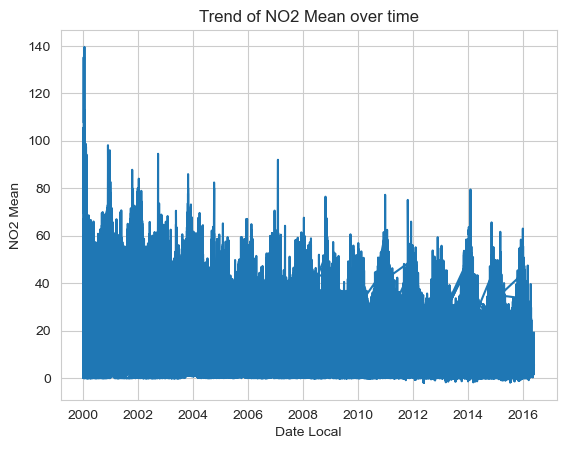

In [38]:
df['Year'] = pd.DatetimeIndex(df['Date_Local']).year
df['Month'] = pd.DatetimeIndex(df['Date_Local']).month
plt.plot(df['Date_Local'], df['NO2_Mean'])
plt.xlabel('Date Local')
plt.ylabel('NO2 Mean')
plt.title('Trend of NO2 Mean over time')
plt.show()


- Nhận xét:
    + Dễ dàng thấy rằng các đỉnh nồng độ NO2 ngày càng giảm dần theo thời gian
    + Điều này cho thấy trend của nồng độ NO2 vẫn là giảm dần


- Biểu đồ chu kỳ:

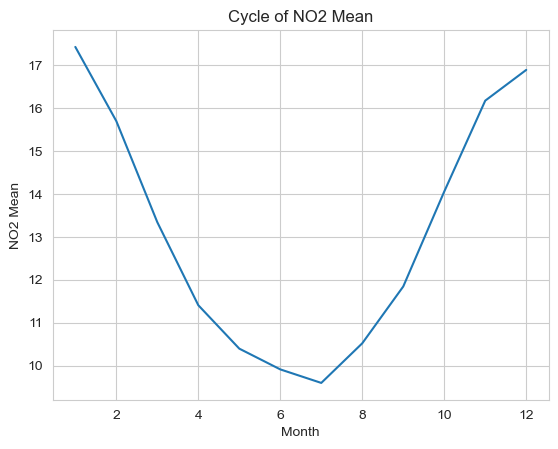

In [39]:
df_cycle = df.groupby(['Month'])['NO2_Mean'].mean()
plt.plot(df_cycle.index, df_cycle.values)
plt.xlabel('Month')
plt.ylabel('NO2 Mean')
plt.title('Cycle of NO2 Mean')
plt.show()


- Nhận xét:
  + Chu kỳ nồng độ CO2 thường đạt đỉnh vào tháng 1, sau đó có xu hướng giảm dần tới tháng 7 và bật tăng trở lại tới tháng 1.

- Biểu đồ thời vụ:

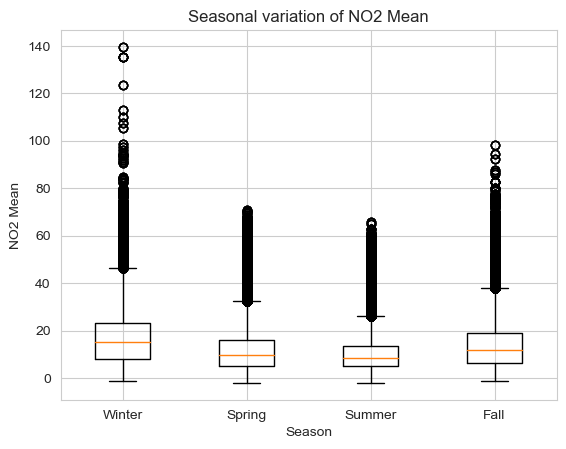

In [40]:
df_season = df.copy()
df_season['Season'] = df_season['Month'].apply(lambda x: 'Winter' if (x == 12 or x <= 2) else ('Spring' if (x >= 3 and x <= 5) else ('Summer' if (x >= 6 and x <= 8) else 'Fall')))
df_season = df_season.sort_values(by='Season')

fig, ax = plt.subplots()
ax.boxplot([df_season[df_season['Season'] == 'Winter']['NO2_Mean'], df_season[df_season['Season'] == 'Spring']['NO2_Mean'], df_season[df_season['Season'] == 'Summer']['NO2_Mean'], df_season[df_season['Season'] == 'Fall']['NO2_Mean']])
ax.set_xticklabels(['Winter', 'Spring', 'Summer', 'Fall'])
plt.xlabel('Season')
plt.ylabel('NO2 Mean')
plt.title('Seasonal variation of NO2 Mean')
plt.show()


- Nhận xét:
  + Mùa đông thường là mùa có nồng độ CO2 cao nhất, trong khi đó mùa hè là mùa có nồng độ CO2 thập nhất
  + Nồng độ NO2 thường cao nhất vào mùa xuân, sau đó giảm dần tới mùa hè và rồi tăng trở lại vào mùa thu

- Biểu đồ noise:

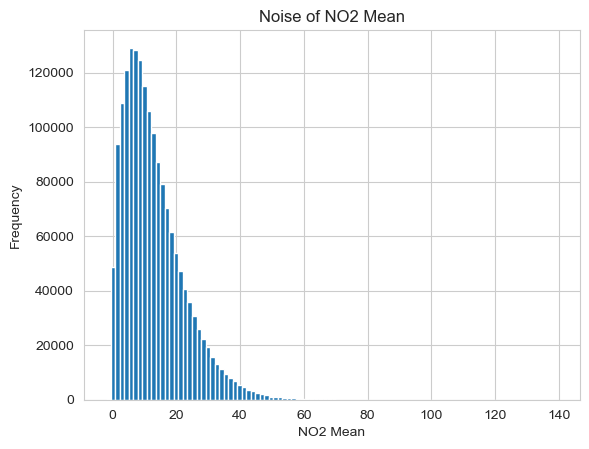

In [41]:
plt.hist(df['NO2_Mean'], bins=100)
plt.xlabel('NO2 Mean')
plt.ylabel('Frequency')
plt.title('Noise of NO2 Mean')
plt.show()


- Nhận xét:
  + Dữ liệu NO2_Mean phân bố đều trong phạm vi giá trị từ khoảng 0 đến khoảng 60
  + Điều này cho thấy sự  ổn định của dữ liệu từ khoảng 0 đến khoảng 60
  + Khi nồng độ NO2 càng cao thì tần suất phân bố càng thấp

## **D. Xây dựng mô hình học máy:**

### **1. Chuẩn bị dữ liệu**: 

### **2. Xây dựng mô hình**

### **3. Trực quan hóa mô hình:**

## **E. Tài liệu tham khảo**

https://simerp.io/blog/tim-hieu-nhu-cau-khach-hang/

https://vitalflux.com/pca-explained-variance-concept-python-example/

https://www.datacamp.com/tutorial/decision-tree-classification-python

https://www.kaggle.com/code/utkarshsaxenadn/shop-customer-clustering?fbclid=IwAR29tq6_MlfU848Svyr_Rghg9U3nxiIYaZa3kHgURPZvRh1NwN8Lo8wrkp0